# Neural ODEs

This page discusses *Neural Ordinary Differential Equations*.{cite}`chen2018neural` The contribution of this paper is really on the ODE side, and in particular on taking derivatives through ODEs, rather than on the neural side. They present the self adjoint sensitivity method for taking derivatives through ODEs. This method was known before this work (see [David Duvenaud's retrospective talk](https://slideslive.com/38923497/bullshit-that-i-and-others-have-said-about-neural-odes)), so in some sense, the authors' real contribution was [porting the self adjoint method to pytorch](https://github.com/rtqichen/torchdiffeq) and using it in the context of ODEs and Normalising Flows.

In [16]:
from IPython.display import HTML, set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Ordinary differential equations

Here is the problem statement. Let $\mathbf{z} \in \mathbb{R}^N$ be a vector whose dynamics evolve according to the [ordinary differential equation](https://mathworld.wolfram.com/OrdinaryDifferentialEquation.html)

$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$

where $\mathbf{\theta} \in \mathbb{R}^P$ and let $\text{ODEsolve}(\mathbf{z}_0, t_0, t_1, \theta)$ denote the solution to this ODE, where $\mathbf{z}(t_0) = \mathbf{z}_0$. Also let $L : \mathbb{R}^N \to \mathbb{R}$ be a loss function. We want to compute the derivatives of the loss $L(\text{ODEsolve}(\mathbf{z}_0, t_0, t_1, \theta))$ with respect to the parameters $\mathbf{\theta}$.

One way to do this would be to solve numerically for $\mathbf{z}(t_1)$ and then backpropagate through the numerical integration routine. Numerical integration routines like [Runge Kutta](https://mathworld.wolfram.com/Runge-KuttaMethod.html) involve only summations and evaluations of $\mathbf{f}$, so we could implement such an algorithm using an automatic differentiation library, run the numerical integration forwards, and then backpropagate through it. However, this requires that we retain the intermediate values of $\mathbf{z}(t)$ that the solver used during integration (much like we need to retain the activations of a neural network), which would incur a memory cost of $\mathcal{O}(T)$ where $T = t_1 - t_0$ is the time interval we are solving over.

## The self-adjoint sensitivity method

The Neural ODE paper proposes first solving the ODE foward from $t_0$ to $t_1$, and then setting up a new differential equation which when solved backwards from $t_1$ to $t_0$ will give us the derivatives of $L$ w.r.t. $\mathbf{\theta}.$ This has two convenient implications. First, we do not need to retain the intermediate $\mathbf{z}$ in memory, because we won't be backpropagating through the ODE solver. Second, we can use off-the-shelf numerical integrators to solve this new backward equation. So there is no need to implement a new solver that supports automatic differentiation.

Let's look at the details of this method, which hinges on two key insights. First, we define the adjoint, which we will use to set up the backward equation.

<div class='definition'>

**Definition (Adjoint)** Given $\mathbf{z}(t) \in \mathbb{R}^N$ for $t \in [t_0, t_1]$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint is defined as
    
$$ \mathbf{a}(t) = \frac{\partial L}{\partial \mathbf{z}(t)}. $$
    
</div>
<br>

The first piece of insight is that the adjoint itself obeys a differential equation, stated and proved below.

<div class='theorem'>

**Result (Differential equation of the adjoint)** Given an ODE of the form
    
$$\frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t),$$
    
the adjoint $\mathbf{a}(t)$ obeys the differential equation

$$ \frac{d \mathbf{a}}{dt} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a},$$
    
</div>
<br>


<details class="proof">
<summary>Proof: Differential equation of the adjoint</summary>

<div>
    
Starting from the relation
    
$$\begin{align}
\mathbf{a}(t) &= \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \frac{d L}{d \mathbf{z}(t + \epsilon)} = \frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} \mathbf{a}(t + \epsilon),
\end{align}$$
    
we substitute the following identity
    
$$ \begin{align}
\frac{\partial \mathbf{z}(t + \epsilon)}{\partial \mathbf{z}(t)} &= \frac{\partial}{\partial \mathbf{z}} \left[\mathbf{z}(t) + \int_t^{t + \epsilon} \mathbf{f}(\mathbf{z}, t) dt \right] = \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2),
\end{align}$$
    
to obtain the relation
    
$$\begin{align}
\mathbf{a}(t) = \left[ \mathbf{I} + \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon),
\end{align}$$
    
Now we write the change in $\mathbf{a}$ from $t$ to $t + \epsilon$ as
    
$$\begin{align}
\mathbf{a}(t + \epsilon) - \mathbf{a}(t) = \left[ - \epsilon \frac{\partial \mathbf{f}}{\partial \mathbf{z}} + \mathcal{O}(\epsilon^2) \right] \mathbf{a}(t + \epsilon).
\end{align}$$
    
Dividing by $\epsilon$ and taking the limit $\epsilon \to 0$ we arrive at
    
$$\begin{align}
\frac{d \mathbf{a}}{d t} = - \frac{\partial \mathbf{f}}{\partial \mathbf{z}} \mathbf{a},~~\text{ where } \left(\frac{\partial \mathbf{f}}{\partial \mathbf{z}}\right)_{ij} = \frac{\partial f_j}{\partial z_i}.
\end{align}$$
 
</div>

</details>
<br>

Now if we integrate the differential equation of the adjoint from $T$ to $t$ we obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}(t)} = \mathbf{a}(T) + \int_t^T \frac{d \mathbf{f}}{d \mathbf{z}} \mathbf{a}~dt.
\end{align}$$

It would be great if in addition to $\frac{d L}{d \mathbf{z}(t)}$ we could also compute $\frac{d L}{d \mathbf{\theta}}$ in a similar way. This is where the second piece of insight comes in. If we append $\mathbf{\theta}$ to the state vector $\mathbf{z}$ to obtain the augmented state

$$ \begin{align}
\mathbf{z}_{aug} = \begin{bmatrix}\mathbf{z} \\ \mathbf{\theta} \end{bmatrix},
\end{align}$$

and let this evolve accoding to the ODE

$$ \begin{align}
\frac{d \mathbf{z}_{aug}}{d t} = \mathbf{f}_{aug}(\mathbf{z}_{aug}, \mathbf{\theta}, t),~~\text{ where }~~\mathbf{f}_{aug} = \begin{bmatrix}\mathbf{f} \\ 0 \end{bmatrix},
\end{align}$$

then the augmented adjoint obeys

$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

We can then integrate this equation in precisely the same way as above to obtain

$$ \begin{align}
\frac{d L}{d \mathbf{z}_{aug}(t)} \equiv \left[\frac{d L}{d \mathbf{z}(t)}, \frac{d L}{d \mathbf{\theta}}\right] = \mathbf{a}_{aug}(T) + \int_t^T \frac{d \mathbf{f}_{aug}}{d \mathbf{z}_{aug}} \mathbf{a}_{aug}~dt,
\end{align}$$

arriving at the derivative $\frac{d L}{d \mathbf{\theta}}$ which are after. In practice, when solving backwards the above intetgral, we will require $\mathbf{z}$ at each time instance, so we can append the dynamics of the $\mathbf{z}$ vector to obtain an equation we can solve backwards. Putting this together with the forward solve we have the following algorithm, called the adjoint sensitivity method.


<div class='definition'>

**Definition (ODE gradients with the adjoint sensitivity method)** Given $\mathbf{z}(t) \in \mathbb{R}^N, t \in [t_0, t_1]$ evolving according to 
  
$$ \frac{d\mathbf{z}}{dt} = \mathbf{f}(\mathbf{z}, \mathbf{\theta}, t), $$
    
where $\mathbf{\theta} \in \mathbb{R}^P$ and let $L : \mathbb{R}^N \to \mathbb{R}$, with the initial condition $\mathbf{z}_0$ and a function $L : \mathbb{R}^N \to \mathbb{R}$, the adjoint sensitivity method computes the derivatives of $L$ w.r.t. $\mathbf{\theta}$ in two steps:
    
1. Solve the above ODE for $\mathbf{z}(t_1) = \mathbf{z}_1$ and compute $\mathbf{a}(t_1) = \mathbf{a}_1$.
2. Solve the following ODE from time $t = t_1$ to $t = t_0$
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$
    
</div>
<br>



<details class="proof">
<summary>Derivation: ODE gradients with the adjoint sensitivity method</summary>
    
Here we derive the ODE in the second step of the above algorithm. The matrix $\frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}}$ in the expression
    
$$ \frac{d \mathbf{a}_{aug}}{dt} = - \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} \mathbf{a}_{aug}. $$

is given by the following expression 

$$ \frac{\partial \mathbf{f}_{aug}}{\partial \mathbf{z}_{aug}} = \begin{bmatrix}
\frac{d\mathbf{f}}{d\mathbf{z}} & \mathbf{0}  \\
\frac{d\mathbf{f}}{d\mathbf{\theta}} & \mathbf{0}  \end{bmatrix}.$$

Hence, the augmented adjoint obeys

$$ \begin{align}
\frac{d \mathbf{a}_{aug}}{d t} = \frac{d}{d t} \begin{bmatrix} \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}.
\end{align}$$

In order to evaluate the expression on the RHS at any time $t$ during the backward solve, we will need to know $\mathbf{z}(t)$. We therefore explicitly include the evolution of $\mathbf{z}$ in the ODE, arriving at the ODE problem
    
$$\begin{align}
\frac{d}{d t} \begin{bmatrix} \mathbf{z} \\ \frac{\partial L}{\partial \mathbf{z}} \\ \frac{\partial L}{\partial \mathbf{\theta}} \end{bmatrix} = \begin{bmatrix} \mathbf{f} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{z}}\mathbf{a} \\ - \frac{\partial \mathbf{f}}{\partial \mathbf{\theta}}\mathbf{a} \end{bmatrix}, \text{ with init. cond. } \left[\mathbf{z}_1, \mathbf{a}_1, \mathbf{\theta} \right].
\end{align}$$

</details>
<br>

## Visualising trajectories

Before implementing this algorithm, let's have a look at what the trajecotries from our model may look like. Let's set $\mathbf{f}$ to be a neural network with a single hidden layer, with randomly initialised weights. We do not need derivatives, so we'll keep things simple for now and implement the transition dynamics $\mathbb{f}$ in Numpy.

In [35]:
import numpy as np

class TransitionDynamics:
    
    def __init__(self, hidden_size, state_size):
        
        self.W1 = np.random.normal(size=(hidden_size, state_size),
                                   loc=0,
                                   scale=state_size**-0.5)
        
        self.b1 = np.random.normal(size=(hidden_size,))
        
        self.W2 = np.random.normal(size=(state_size, hidden_size),
                                   loc=0,
                                   scale=hidden_size**-0.5)
        
        self.b2 = np.random.normal(size=(state_size,))
        
    
    def __call__(self, t, x):
        
        assert len(x.shape) == 1
        
        x = np.dot(self.W1, x)
        x = x + self.b1
        
        x = np.tanh(x)
        
        x = np.dot(self.W2, x)
        x = x + self.b2
        
        return x

Now we sample nine such models (each corresponding to one of the squares below). For each model we sample initial points uniformly at random, and solve the ODE defined by the model forwards, to obtain the trajectories shown.

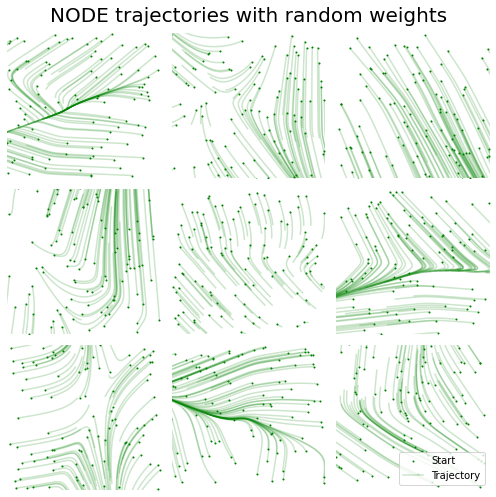

In [36]:
from scipy.integrate import ode as ODE
from matplotlib import pyplot as plt

# Set random seed to sample same weights each time
np.random.seed(1)

# Set integration parameters
t0 = 0.
t1 = 10.
num_traj = 100
num_steps = 50
dt = t1 / num_steps

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# Simulate and plot
plt.figure(figsize=(7, 7))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    # New transition dynamics with random weights
    transition_dynamics = TransitionDynamics(hidden_size=3, state_size=2)

    for seed in range(num_traj):

        # Sample initial states
        y0 = 20 * (np.random.rand(2) - 0.5)

        # Array to store states
        states = np.zeros(shape=(0, 2))

        # Set ODE integrator
        ode = ODE(f=transition_dynamics.__call__).set_integrator('vode')
        ode = ode.set_initial_value(y0, t0)

        # Integrate numerically within time interval
        while ode.successful() and ode.t < t1:
            states = np.concatenate([states, ode.integrate(ode.t + dt)[None, :]], axis=0)
            
        # Plot starting point and trajectory
        s = plt.scatter(states[0, 0], states[0, 1], color='green', marker='o', s=1, zorder=2)
        p, = plt.plot(states[:, 0], states[:, 1], color='green', alpha=0.2, zorder=1)
        
        if i == 8 and seed == 0: plt.legend([s, p], ['Start', 'Trajectory'], loc='lower right')
    
    plt.axis('off')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
plt.suptitle('NODE trajectories with random weights', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The Neural ODE models seem to be able to demonstrate a variety of different dynamics.

## Implementation

Now let's implement the full model with backwards and forwards dynamics. To apply the adjoint sensitivity method, we will have to differentiate through the transition function $\mathbf{f}$ as well as the loss function $L$. We'll therefore impement the NODE as a tensorflow module.

In [37]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp

tfd = tfp.distributions

class NODE(tf.Module):
    """
    ODE model whose dynamics are expressed using a neural network with
    a single hidden layer, with a tanh nonlinearity.
    """
    
    def __init__(self, hidden_size, state_size, dtype, name='node'):
        
        super().__init__()
        
        self.dtype = dtype
        self.state_size = state_size
        
        self.W1 = tf.random.normal(shape=(state_size, hidden_size),
                                   mean=0.,
                                   stddev=state_size**-0.5,
                                   dtype=dtype)
        self.W1 = tf.Variable(self.W1)
        
        self.b1 = tf.random.normal(shape=(1, hidden_size),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b1 = tf.Variable(self.b1)
        
        self.W2 = tf.random.normal(shape=(hidden_size, state_size),
                                   mean=0,
                                   stddev=hidden_size**-0.5,
                                   dtype=dtype)
        self.W2 = tf.Variable(self.W2)
        
        self.b2 = tf.random.normal(shape=(1, state_size),
                                   mean=0.,
                                   stddev=1.,
                                   dtype=dtype)
        self.b2 = tf.Variable(self.b2)
        
    
    def f(self, t, z):
        """
        The forward dynamics of the ODE.
        """
        
        z = tf.convert_to_tensor(z, dtype=self.dtype)
        z = tf.reshape(z, (-1, self.state_size))
        
        f = tf.einsum('ni, ij -> nj', z, self.W1)
        f = f + self.b1
        
        f = tf.cast(tf.tanh(f), dtype=self.dtype)
        
        f = tf.einsum('ni, ij -> nj', f, self.W2)
        f = f + self.b2
        
        return f
    
    
    def w(self, t, za):
        """
        The auugmented backward dynamics of the ODE.
        """
        
        num_params = tf.reduce_sum([tf.reduce_prod(tensor.shape) \
                                    for tensor in self.trainable_variables])
        last_dim = 2 * self.state_size + num_params
        
        za = tf.convert_to_tensor(za, dtype=self.dtype)
        za = tf.reshape(za, (-1, last_dim))
        
        z = za[:, :self.state_size] # (B, Z)
        a = za[:, self.state_size:2*self.state_size] # (B, Z)
        
        f, dfdz_a, dfdtheta_a = self.jacobians(t, z, a)
        
        w = tf.concat([f, dfdz_a] + dfdtheta_a, axis=1)
        
        return w
    
    
    @tf.function
    def jacobians(self, t, z, a):
        """
        Decorate the gradient calculations with a tf.function for improved
        efficiency.
        """
        
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(z)
            tape.watch(self.trainable_variables)

            f = self.f(t, z)
        
        dfdz = tape.batch_jacobian(f, z) # (B, Z, Z) dfdz_ij = (df_i)/dz_j
        dfdz_a = - tf.einsum('nij, ni -> nj', dfdz, a)
        
        dfdtheta = tape.jacobian(f, self.trainable_variables) # list of (B, Z, P[i])
        dfdtheta = [tf.reshape(tensor, (tensor.shape[0], tensor.shape[1], -1)) \
                    for tensor in dfdtheta]
        dfdtheta_a = [- tf.einsum('nij, ni -> nj', tensor, a) for tensor in dfdtheta]
        
        return f, dfdz_a, dfdtheta_a
    
    
    def loglik(self, zpred, zdata):
        """
        Helper that calculates the log-likelihood of data under the model.
        The likelihood function is a diagonal gaussian with unit scale,
        centered at the predictions.
        """

        assert zpred.shape == zdata.shape

        dist = tfd.MultivariateNormalDiag(loc=zpred, scale_identity_multiplier=1e0)

        # Loglik of each state dimension, for each datapoint (B, Z)
        loglik = dist.log_prob(zdata)
        
        # Average log likelihood over batch
        loglik = tf.reduce_sum(loglik)

        return loglik
    
    
    def backward_initial_conditions(self, t, z, zdata):
        """
        Helper that computes the initial conditions for the backwards solve
        at some time t and position z.
        """
        
        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(z)
            
            L = - self.loglik(z, zdata)
            
        dLdz = tape.gradient(L, z)
        
        zeros = [tf.zeros(shape=(z.shape[0], tf.reduce_prod(tensor.shape)), dtype=self.dtype) \
                 for tensor in self.trainable_variables]
        
        init_cond = tf.concat([z, dLdz] + zeros, axis=1)
        
        return init_cond
    
    
    def gradients_from_za(self, za):
        """
        Helper to unpack the gradients of the parameters from a flat [z, a]
        vector, into the shapes used by the model.
        """
        
        var_sizes = [tf.reduce_prod(variable.shape) for variable in self.variables]
        za_size = 2 * self.state_size + tf.reduce_sum(var_sizes)
        
        za = tf.convert_to_tensor(za, dtype=self.dtype)
        za = tf.reshape(za, (-1, za_size))
        
        gradients = tf.reduce_sum(za[:, 4:], axis=0)
        
        idx_start = 0
        variable_gradients = []
        
        for variable in self.variables:
            
            variable_shape = variable.shape
            variable_size = tf.reduce_prod(variable_shape)
            
            variable_gradient = gradients[idx_start:idx_start+variable_size]
            variable_gradient = tf.reshape(variable_gradient, variable_shape)
            
            idx_start = idx_start + variable_size
            
            variable_gradients.append(variable_gradient)
        
        return variable_gradients
    
    
    def solve(self, init_cond, t0, t1, dt, atol, forward):
        """
        Helper that does a forward or backward solve between t0 < t1.
        The parameter atol is the absolute error tolerance for the ODE solver.
        """
        
        if forward:
            
            f = lambda t, z : tf.reshape(self.f(tf.cast(t, dtype=self.dtype), z), (-1,))
            ode = ODE(f=f).set_integrator('vode', atol=atol)
            ode = ode.set_initial_value(np.reshape(init_cond, (-1,)), t0)
            
            while ode.successful:
                solution = ode.integrate(ode.t + dt)
                
                if ode.t > t1: return solution
        
        else:
            
            f = lambda t, za : tf.reshape(self.w(tf.cast(t, dtype=self.dtype), za), (-1,))
            ode = ODE(f=f).set_integrator('vode', atol=atol)
            ode = ode.set_initial_value(np.reshape(init_cond, (-1,)), t1)
            
            while ode.successful:
                solution = ode.integrate(ode.t - dt)
                
                if ode.t < t0: return solution

As a sanity check, let's draw some models at random again, and do a forwards solve to inspect the trajectories.

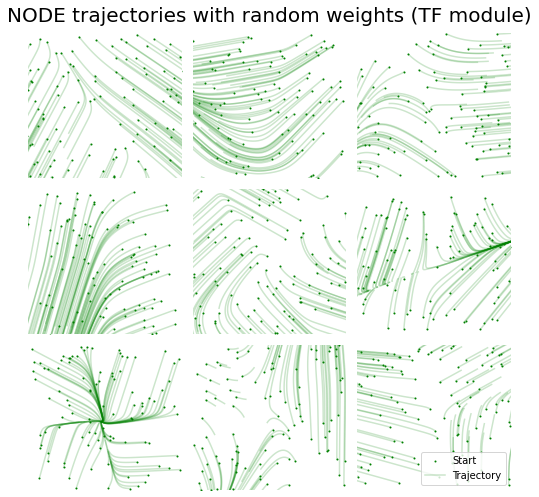

In [38]:
# Set random seed to sample same weights each time
np.random.seed(1)
dtype = tf.float64

# Set integration parameters
t0 = 0.
t1 = 10.
num_traj = 100
num_steps = 50
dt = t1 / num_steps

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# Simulate and plot
plt.figure(figsize=(7, 7))

for i in range(9):

    plt.subplot(3, 3, i + 1)

    # New transition dynamics with random weights
    node = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)
    
    # Random initial states
    z0 = 20 * (np.random.uniform(size=(num_traj, state_size)) - 0.5)
    z0 = tf.convert_to_tensor(z0, dtype=dtype)
    z0 = tf.reshape(z0, (-1,))

    # Set ODE integrator
    ode = ODE(f=lambda t, z : tf.reshape(node.f(t, z), (-1,))).set_integrator('vode')
    ode = ode.set_initial_value(z0, t0)
    
    # For storing intermediate states for plotting
    states = np.zeros(shape=(num_traj, 0, state_size))

    # Integrate numerically within time interval
    while ode.successful() and ode.t < t1:
        next_states = np.reshape(ode.integrate(ode.t + dt), (num_traj, 1, state_size))
        states = np.concatenate([states, next_states], axis=1)
    
    # Plot starting point and trajectory
    s = plt.scatter(states[:, 0, 0], states[:, 0, 1], color='green', marker='o', s=1, zorder=2)
    
    # Plot the trajectories
    for n in range(num_traj):
        p, = plt.plot(states[n, :, 0], states[n, :, 1], color='green', alpha=0.2, zorder=1)
        
        if i == 8 and n == 0: plt.legend([s, p], ['Start', 'Trajectory'], loc='lower right')
    
    plt.axis('off')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    
plt.suptitle('NODE trajectories with random weights (TF module)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Training on synthetic data

Now we will pick such a model, draw some data from it, and train another model using that data. The new model better be able to learn the dynamics of the first one.

In [47]:
# Set random seeds and dtype
np.random.seed(0)
tf.random.set_seed(0)
dtype = tf.float32

# Set integration parameters
t0 = 0.
t1 = 10.
num_steps = 50
dt = t1 / num_steps
num_datapoints = 500
atol = 1e-4

# Hidden size for transition dynamics
hidden_size = 3

# Set state size to 2 for 2D plots
state_size = 2

# New transition dynamics with random weights
node_ground_truth = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)

# Initial positions
z0 = 20 * (np.random.uniform(size=(num_datapoints * state_size)) - 0.5)

# Numerical solve for final conditions
z1 = node_ground_truth.solve(z0, t0, t1, dt, atol, forward=True)

loglik = node_ground_truth.loglik(tf.reshape(z1, shape=(-1, state_size)),
                                  tf.reshape(z1, shape=(-1, state_size))) / num_datapoints

print(f'Drew {num_datapoints:4d} datapoints from the ground truth. '
      f'Log-likelihood (per datapoint): {loglik:.3f}')

Drew  500 datapoints from the ground truth. Log-likelihood (per datapoint): -1.838


Now let's draw a new model with randomly initialised weights, and train it using the data drawn above.

In [25]:
# Change random seeds to draw different model
np.random.seed(1)
tf.random.set_seed(1)

num_train_steps = 1000
learning_rate = 1e-2

# New transition dynamics with random weights
node_learnt = NODE(hidden_size=hidden_size, state_size=state_size, dtype=dtype)

z1_data = tf.convert_to_tensor(np.reshape(z1, (-1, state_size)), dtype=dtype)

optimiser = tfk.optimizers.Adam(learning_rate=learning_rate)

for i in range(num_train_steps + 1):
    
    z1_pred = node_learnt.solve(z0, t0, t1, dt, atol, forward=True)
    
    z1_pred = tf.convert_to_tensor(np.reshape(z1_pred, (-1, state_size)), dtype=dtype)

    za1 = node_learnt.backward_initial_conditions(t1, z1_pred, z1_data)
    za1 = tf.reshape(za1, (-1,))
    
    za0 = node_learnt.solve(za1, t0, t1, dt, atol, forward=False)
    
    gradients = node_learnt.gradients_from_za(za0)
    
    optimiser.apply_gradients(zip(gradients, node_learnt.variables))

    if i % 50 == 0:
        loglik = node_learnt.loglik(tf.reshape(z1_pred, shape=(-1, state_size)),
                                    tf.reshape(z1_data, shape=(-1, state_size))) / num_datapoints
        print(f'step: {i:4d} log-likelihood (per datapoint): {loglik:10.3f}')

step:    0 log-likelihood (per datapoint):   -283.869
step:   50 log-likelihood (per datapoint):    -50.833
step:  100 log-likelihood (per datapoint):     -7.577
step:  150 log-likelihood (per datapoint):     -2.579
step:  200 log-likelihood (per datapoint):     -2.199
step:  250 log-likelihood (per datapoint):     -2.061
step:  300 log-likelihood (per datapoint):     -2.002
step:  350 log-likelihood (per datapoint):     -1.975
step:  400 log-likelihood (per datapoint):     -1.962
step:  450 log-likelihood (per datapoint):     -1.955
step:  500 log-likelihood (per datapoint):     -1.951
step:  550 log-likelihood (per datapoint):     -1.949
step:  600 log-likelihood (per datapoint):     -1.946
step:  650 log-likelihood (per datapoint):     -1.945
step:  700 log-likelihood (per datapoint):     -1.943
step:  750 log-likelihood (per datapoint):     -1.941
step:  800 log-likelihood (per datapoint):     -1.939
step:  850 log-likelihood (per datapoint):     -1.938
step:  900 log-likelihood (p

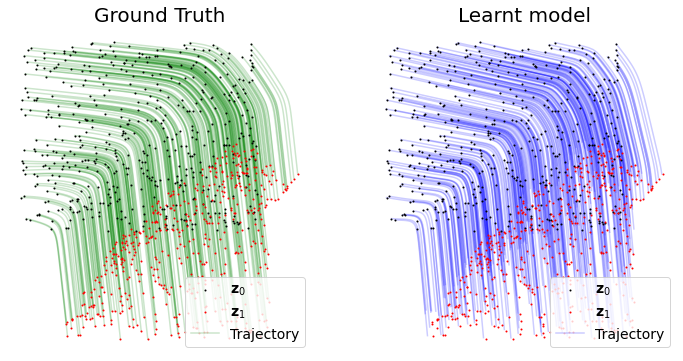

In [52]:
# Simulate and plot
plt.figure(figsize=(12, 6))

titles = ['Ground Truth', 'Learnt model']
colors = ['green', 'blue']

for i, model in enumerate([node_ground_truth, node_learnt]):
    
    plt.subplot(1, 2, i + 1)

    # Set ODE integrator
    ode = ODE(f=lambda t, z : tf.reshape(model.f(t, z), (-1,))).set_integrator('vode')
    ode = ode.set_initial_value(z0, t0)

    # For storing intermediate states for plotting
    states = np.reshape(z0, (-1, 1, state_size)) # np.zeros(shape=(num_datapoints, 0, state_size))

    # Integrate numerically within time interval
    while ode.successful() and ode.t < t1:
        next_states = np.reshape(ode.integrate(ode.t + dt), (num_datapoints, 1, state_size))
        states = np.concatenate([states, next_states], axis=1)

    # Plot starting point and trajectory
    z0_ = np.reshape(z0, (-1, 2))
    z1_ = np.reshape(z1, (-1, 2))
    
    s1 = plt.scatter(z0_[:, 0], z0_[:, 1], color='k', marker='o', s=1, zorder=2)
    s2 = plt.scatter(z1_[:, 0], z1_[:, 1], color='red', marker='o', s=1, zorder=2)

    # Plot the trajectories
    for n in range(num_datapoints):
        p, = plt.plot(states[n, :, 0], states[n, :, 1], color=colors[i], alpha=0.2, zorder=1)
        plt.legend([s1, s2, p], 
                   [r'$\mathbf{z}_0$', r'$\mathbf{z}_1$', 'Trajectory'],
                   loc='lower right',
                   fontsize=14)

    plt.title(titles[i], fontsize=20)
    plt.axis('off')

plt.show()

We see that the learnt model has roughly learnt to predict $\mathbf{z}_1$ from $\mathbf{z}_0$. The trajectories themselves are roughly similar to the ground truth model but not entirely the same - there is no reason the model would reproduce the shapes of the trajectories exactly in regions where there are no data. With further training, a better-tuned learning rate and stricter error tolerance, we can train the new model to predict $\mathbf{z}_1$ much more closely.

## Conclusions and follow-up work

That's it for now. There are several things this page has not touched on, including using ODE solvers for Continuous Normalising flows,{cite}`chen2018neural` ODEs in the context of latent variable models{cite}`rubanova2019latent` or learning real datasets. There are several interesting follow-up works on Neural ODEs. One such follow-up is the Augmented Neural ODE {cite}`dupont2019augmented` model. ODEs preserve the topology of the input space (they are a [diffeomorphism](https://mathworld.wolfram.com/Diffeomorphism.html)) and therefore cannot learn certain functions of interest. Augmented Neural ODEs fix this by adding auxiliary dimensions, and solving in the augmented space. Another interesting follow-up is the Neural Controlled ODE{cite}`kidger2020neural` model. Given the initial conditions and ODE dynamics, the trajectory of the model is fully determined. The whole trajectory must therefore be encoded in the initial state, regardless of how long this trajectory is. We can imagine having to pack more and more information into the initial state is difficult. Neural CDEs address this issue by introducing a more flexible class of models. These models do not have the nice Markov property that ODE or other time series models (like RNNs or LSTMs) have, nor do they correspond to well-defined processes for generating data. However, they do help with learning more complicated functions and constitute a more expressive class of models. Lastly, [David Duvenaud's retrospective talk](https://slideslive.com/38923497/bullshit-that-i-and-others-have-said-about-neural-odes) on Neural ODEs is worth watching.

## References

```{bibliography} ./node-references.bib
```